## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2
import timeit

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

#### Initialisation

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 32.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [3]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/drill/n03239726_19191.JPEG,5
1,imagenet10/train_set/banana/n07753592_8041.JPEG,1
2,imagenet10/train_set/cat/n02123159_7934.JPEG,3
3,imagenet10/train_set/football/n04254680_4198.JPEG,7
4,imagenet10/train_set/baboon/n02486410_5063.JPEG,0


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [10]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:40<00:00, 222.56it/s]


(224, 224, 3, 9000)
normMean = [0.5228344, 0.47988218, 0.40605018]
normStd = [0.29770824, 0.28884, 0.31178245]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)

#### Model Definition

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(26912, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Creating a model object. If a GPU is available, use it instead.

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)

#### Training Definition

Creating a seed.

In [16]:
torch.manual_seed(0)

Defining a train function

In [0]:
def train(device, model, train_loader, valid_loader, optimizer=None, criterion=nn.CrossEntropyLoss(), verbose=True):
    """ Training for one epoch 
    """

    #Initialise all the important variables
    running_loss = 0.
    total_running_loss = 0.
    lentl = len(train_loader)//10 # length of the loader, for loss calculations. 10 represents the number of print statements
    total = 0
    correct = 0
    

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for i, data in enumerate(train_loader, 0):
        model.train(True)
        images, labels = data # get the data

        # Putting the data on to the device
        images = images.to(device)  
        labels = labels.to(device) 

        # Clear the gradients so they don't accumalate
        optimizer.zero_grad()

        # Get the outputs of the model
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Perform backpropagation
        loss.backward()
        optimizer.step()

        
        # Get the loss
        running_loss += loss.item()
        total_running_loss += loss.item()

        # Get the highest percent prediction from the model
        _, predicted = torch.max(outputs.data, 1)
        
        # Get whether the predictions were correct according to the labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        #Print every 10th batch of an epoch
        if i % lentl == (lentl-1) and verbose:
            print('Epoch / Batch [%d / %d] - Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / lentl))
            running_loss = 0.0
    
    # It's possible to turn the print statements off by supplying a True/False arguments
    # Useful for displaying filters, as I only wanted to see the filters
    if verbose:
        print('Epoch %d - Loss: %.3f' % (epoch + 1, total_running_loss/len(train_loader)))
        print('Accuracy of the epoch throughout training: %d %%' % (100 * correct / total)) 

    #Validation, which is the same as training, but no backpropagation
    total_val_loss = 0.
    for i, data in enumerate(valid_loader, 0):
        model.train(False)
        
        # Get the data
        images, labels = data
        
        images = images.to(device) 
        labels = labels.to(device) 
        
        # Get the outputs of the model
        outputs = model(images)
        
        # And calculate the loss. 
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()

    # Print out the overall loss during the epoch
    if verbose:
        print("Validation loss = {:.2f}".format(total_val_loss / len(valid_loader)))


#### Train and Save

In [0]:
# For every epoch train once
for epoch in range(10):
    train(device, model, train_loader, valid_loader)

Epoch / Batch [1 / 39] - Loss: 2.300
Epoch / Batch [1 / 78] - Loss: 2.257
Epoch / Batch [1 / 117] - Loss: 2.155
Epoch / Batch [1 / 156] - Loss: 2.117
Epoch / Batch [1 / 195] - Loss: 2.096
Epoch / Batch [1 / 234] - Loss: 2.090
Epoch / Batch [1 / 273] - Loss: 2.061
Epoch / Batch [1 / 312] - Loss: 2.056
Epoch / Batch [1 / 351] - Loss: 2.008
Epoch / Batch [1 / 390] - Loss: 2.012
Epoch 1 - Loss: 2.114
Accuracy of the epoch throughout training: 21 %
Validation loss = 1.90
Epoch / Batch [2 / 39] - Loss: 2.015
Epoch / Batch [2 / 78] - Loss: 1.974
Epoch / Batch [2 / 117] - Loss: 1.995
Epoch / Batch [2 / 156] - Loss: 1.990
Epoch / Batch [2 / 195] - Loss: 1.956
Epoch / Batch [2 / 234] - Loss: 1.967
Epoch / Batch [2 / 273] - Loss: 1.968
Epoch / Batch [2 / 312] - Loss: 1.897
Epoch / Batch [2 / 351] - Loss: 1.926
Epoch / Batch [2 / 390] - Loss: 1.951
Epoch 2 - Loss: 1.964
Accuracy of the epoch throughout training: 28 %
Validation loss = 1.86
Epoch / Batch [3 / 39] - Loss: 1.859
Epoch / Batch [3 / 78

In [0]:
# Save the model for later use
torch.save({'state_dict': model.state_dict()}, 'model.pth.tar')

#### Testing

In [0]:
def test_model(device, model, test_loader):
    correct = 0
    total = 0

    # Remove the gradients as they are not needed
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            # Get the data  
            images, labels = data
            images = images.to(device)  
            labels = labels.to(device)  
            
            # Get the outputs
            outputs = model(images)
            
            # Get the predictions from the model
            _, predicted = torch.max(outputs.data, 1)
            
            # Calculate the accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [0]:
test_model(device, model, test_loader)

Accuracy of the network on the test images: 51 %


### Part II

Now, run two experiments testing various network architectures:

1. How does the number of layers affect the training process and test performance? Try between 2 and 5 layers.
2. Choose one more architectural element to test (filter size, max-pool kernel size, number/dimensions of fully-connected layers, etc.). Generate and display the confusion matrices for the various experiments

Redefine the network to contain more layers.

Also, change the number of filter-size/kernel-size/number of connected layers.

#### Visualising confusion matrix function definition

The function taken from the introduction notebook.

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                     classes,
                     normalize=False,
                     title='Confusion matrix',
                     cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#### Modifying test function to include confusion matrix.

In [0]:
def test_model_and_plot(device, model, test_loader):
    correct = 0
    total = 0

    # Arrays used to store all the predictions and labels needed for confusion matrix.
    total_predicted = []
    total_labels = []

    with torch.no_grad():
        model.eval()

        for data in test_loader:
          
            # Get the data
            images, labels = data

            images = images.to(device) 
            labels = labels.to(device)  
            
            # Get the outputs
            outputs = model(images)
            
            # Get the predicted values
            _, predicted = torch.max(outputs.data, 1)

            # Get all the predicted values and labels and clone them on the cpu.
            curr_predicted = predicted.cpu().clone().numpy()
            curr_labels = labels.cpu().clone().numpy()

            # Append these values to the variables defined above.
            total_predicted.append(curr_predicted.tolist())
            total_labels.append(curr_labels.tolist())

            # Calculate the accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Get the confusion matrix and plot it.
    cm = confusion_matrix(np.array(total_labels).flatten(), np.array(total_predicted).flatten())
    plot_confusion_matrix(cm, np.arange(0, 10))

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

#### Different Layers Experiment Definitions

##### 2 Layers

In [0]:
# Convolutional neural network
class ConvNet2L(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet2L, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(92256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
      
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

##### 3 Layers

In [0]:
# Convolutional neural network
class ConvNet3L(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3L, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(26912, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out



##### 4 Layers

In [0]:
# Convolutional neural network
class ConvNet4L(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet4L, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Fourth Convolutional Layer
        self.cv4 = nn.Conv2d(32, 40, 4)
        self.re4 = nn.ReLU()
        self.mp4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(6760, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Complete the graph

        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))
        x = self.drop4(self.mp4(self.re4(self.cv4(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

##### 5 Layers

In [0]:

# Convolutional neural network
class ConvNet5L(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5L, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Fourth Convolutional Layer
        self.cv4 = nn.Conv2d(32, 40, 4)
        self.re4 = nn.ReLU()
        self.mp4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout2d(p=0.3)

        # Fifth Convolutional Layer
        self.cv5 = nn.Conv2d(40, 48, 4)
        self.re5 = nn.ReLU()
        self.mp5 = nn.MaxPool2d(2)
        self.drop5 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(1200, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))
        x = self.drop4(self.mp4(self.re4(self.cv4(x))))
        x = self.drop5(self.mp5(self.re5(self.cv5(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

#### Filter-Size Experiment Definitions

##### 3 Kernel Size

In [0]:
# Convolutional neural network
class ConvNet3KS(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3KS, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 3)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 3)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(28800, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

##### 5 Kernel Size

In [0]:
# Convolutional neural network
class ConvNet5KS(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5KS, self).__init__()
  
        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 5)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 5)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, num_classes)

        
    def forward(self, x):
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

##### 7 Kernel Size

In [0]:
# Convolutional neural network
class ConvNet7KS(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet7KS, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 7)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 7)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(23328, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Complete the graph

        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

##### 9 Kernel Size

In [0]:
# Convolutional neural network
class ConvNet9KS(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet9KS, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3)
        self.re1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(p=0.3)

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 9)
        self.re2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(p=0.3)

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 9)
        self.re3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout2d(p=0.3)

        # Final fully connected layer
        self.fc1 = nn.Linear(20000, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Complete the graph

        x = self.drop1(self.mp1(self.re1(self.cv1(x))))
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        x = x.reshape(x.size(0), -1)
        out = self.fc2(self.fc1(x))
        
        return out

#### Running the experiment

Defining a timer

In [0]:
def time_train(device, model, train_loader, valid_loader):
    time_took = timeit.timeit(
        lambda: train(device, model, train_loader, valid_loader),
        number=1,
        globals=globals()
    )
    print('Time Took to Train: %.2f' % (time_took))


Initialise all the models.

In [0]:
model2l = ConvNet2L().to(device)
model3l = ConvNet3L().to(device)
model4l = ConvNet4L().to(device)
model5l = ConvNet5L().to(device)

model3ks = ConvNet3KS().to(device)
model5ks = ConvNet5KS().to(device)
model7ks = ConvNet7KS().to(device)
model9ks = ConvNet9KS().to(device)

Train all the models

In [0]:
for epoch in range(10):
  print('2 Layer Model')
  time_train(device, model2l, train_loader, valid_loader)
  print('3 Layer Model')
  time_train(device, model3l, train_loader, valid_loader)
  print('4 Layer Model')
  time_train(device, model4l, train_loader, valid_loader)
  print('5 Layer Model')
  time_train(device, model5l, train_loader, valid_loader)

  print('3 Kernel Size Model')
  time_train(device, model3ks, train_loader, valid_loader)
  print('5 Kernel Size Model')
  time_train(device, model5ks, train_loader, valid_loader)
  print('7 Kernel Size Model')
  time_train(device, model7ks, train_loader, valid_loader)
  print('9 Kernel Size Model')
  time_train(device, model9ks, train_loader, valid_loader)

2 Layer Model
Epoch / Batch [1 / 39] - Loss: 2.269
Epoch / Batch [1 / 78] - Loss: 2.190
Epoch / Batch [1 / 117] - Loss: 2.073
Epoch / Batch [1 / 156] - Loss: 2.005
Epoch / Batch [1 / 195] - Loss: 2.041
Epoch / Batch [1 / 234] - Loss: 1.993
Epoch / Batch [1 / 273] - Loss: 1.964
Epoch / Batch [1 / 312] - Loss: 1.964
Epoch / Batch [1 / 351] - Loss: 1.942
Epoch / Batch [1 / 390] - Loss: 1.922
Epoch 1 - Loss: 2.036
Accuracy of the epoch throughout training: 25 %
Validation loss = 1.89
Time Took to Train: 52.49
3 Layer Model
Epoch / Batch [1 / 39] - Loss: 2.296
Epoch / Batch [1 / 78] - Loss: 2.282
Epoch / Batch [1 / 117] - Loss: 2.223
Epoch / Batch [1 / 156] - Loss: 2.182
Epoch / Batch [1 / 195] - Loss: 2.147
Epoch / Batch [1 / 234] - Loss: 2.152
Epoch / Batch [1 / 273] - Loss: 2.100
Epoch / Batch [1 / 312] - Loss: 2.087
Epoch / Batch [1 / 351] - Loss: 2.056
Epoch / Batch [1 / 390] - Loss: 2.016
Epoch 1 - Loss: 2.153
Accuracy of the epoch throughout training: 21 %
Validation loss = 1.92
Time

#### Saving the models

In [0]:
torch.save({'state_dict': model2l.state_dict()}, 'model2l.pth.tar')
torch.save({'state_dict': model3l.state_dict()}, 'model3l.pth.tar')
torch.save({'state_dict': model4l.state_dict()}, 'model4l.pth.tar')
torch.save({'state_dict': model5l.state_dict()}, 'model5l.pth.tar')

torch.save({'state_dict': model3ks.state_dict()}, 'model4ks.pth.tar')
torch.save({'state_dict': model5ks.state_dict()}, 'model5ks.pth.tar')
torch.save({'state_dict': model7ks.state_dict()}, 'model7ks.pth.tar')
torch.save({'state_dict': model9ks.state_dict()}, 'model9ks.pth.tar')

#### Test the models

------------------------ 2 Layer Model ------------------------
Confusion matrix, without normalization


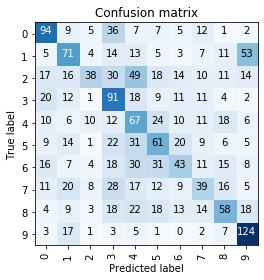

Accuracy of the network on the test images: 38 %
----------------------------------------------------------------------
------------------------ 3 Layer Model ------------------------
Confusion matrix, without normalization


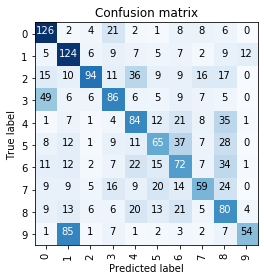

Accuracy of the network on the test images: 46 %
----------------------------------------------------------------------
------------------------ 4 Layer Model ------------------------
Confusion matrix, without normalization


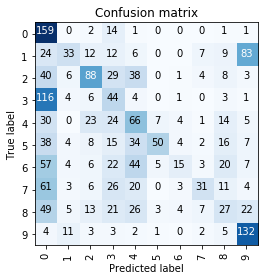

Accuracy of the network on the test images: 35 %
----------------------------------------------------------------------
------------------------ 5 Layer Model ------------------------
Confusion matrix, without normalization


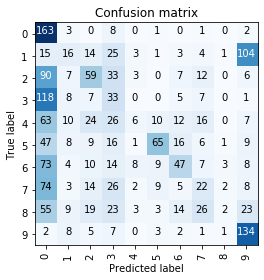

Accuracy of the network on the test images: 30 %
----------------------------------------------------------------------
------------------------ 3 Kernel Size Model ------------------------
Confusion matrix, without normalization


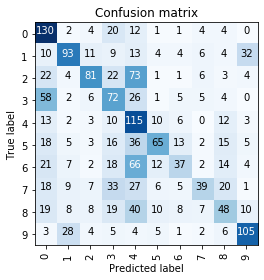

Accuracy of the network on the test images: 43 %
----------------------------------------------------------------------
------------------------ 5 Kernel Size Model ------------------------
Confusion matrix, without normalization


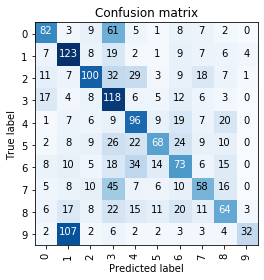

Accuracy of the network on the test images: 45 %
----------------------------------------------------------------------
------------------------ 7 Kernel Size Model ------------------------
Confusion matrix, without normalization


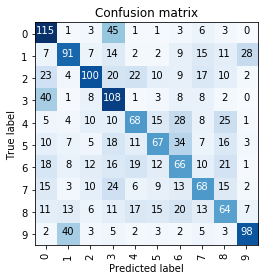

Accuracy of the network on the test images: 46 %
----------------------------------------------------------------------
------------------------ 9 Kernel Size Model ------------------------
Confusion matrix, without normalization


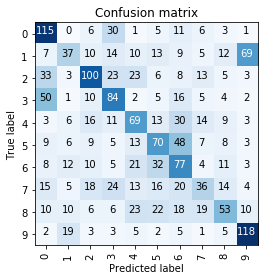

Accuracy of the network on the test images: 42 %
----------------------------------------------------------------------


In [0]:
print('------------------------ 2 Layer Model ------------------------')
test_model_and_plot(device, model2l, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 3 Layer Model ------------------------')
test_model_and_plot(device, model3l, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 4 Layer Model ------------------------')
test_model_and_plot(device, model4l, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 5 Layer Model ------------------------')
test_model_and_plot(device, model5l, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 3 Kernel Size Model ------------------------')
test_model_and_plot(device, model3ks, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 5 Kernel Size Model ------------------------')
test_model_and_plot(device, model5ks, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 7 Kernel Size Model ------------------------')
test_model_and_plot(device, model7ks, test_loader)
print('----------------------------------------------------------------------')

print('------------------------ 9 Kernel Size Model ------------------------')
test_model_and_plot(device, model9ks, test_loader)
print('----------------------------------------------------------------------')

### Part III

Now, choose the best-performing network architecture and visualise the filters from the first layer of the network. Compare the filters before training (random weight initialisation), halfway during training, and after training is completed. Normalise the filters before displaying as an image. The filters are 3D, but are easier to visualise when displayed in grayscale. You can do this using matplotlib.pyplot’s colour map argument: `plt.imshow(filter, cmap=”gray”)`

#### Function that visualises the features

In [0]:
def vis_filters(model):

    # Get the figure to modify it so it looks better
    fig = plt.figure()
    plt.figure(figsize=(10,2))

    # Get the weights from the gpu to the cpu.
    weight = model.cv1.weight.data.clone().cpu()
    
    # For all the feature maps
    for i in range(16):
        # for all the feature channels
        for j in range(3):

            # Clone the weights as they'll be normalised
            norm_weights = weight[i, j, :, :].clone()

            # Create a subplot, and modify the ticks for a better layout.
            ax1 = plt.subplot(3, 16, (i*3)+j+1)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            
            # I used ToPILImage to normalise the data between 0 and 1. 
            # This gave me a more consistent output than regular normalisation.
            plt.imshow(transforms.ToPILImage()(norm_weights), cmap='gray', aspect='auto')
            plt.axis('off')
    plt.show()
    

#### Getting the best model

In [0]:
# The regular 3 convolutional layers 4 kernel-size has performed the best for me.
best_model = ConvNet().to(device)

#### Now visualising before, during and after.

<Figure size 432x288 with 0 Axes>

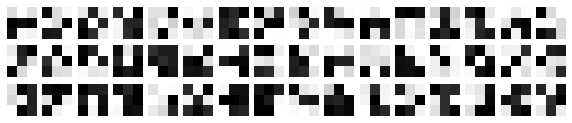

<Figure size 432x288 with 0 Axes>

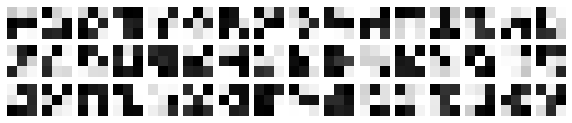

<Figure size 432x288 with 0 Axes>

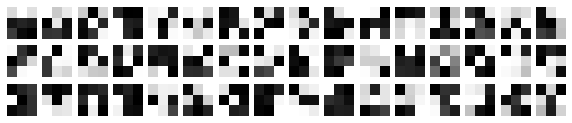

In [0]:
# Visualise the filters before
vis_filters(best_model)

# Train the model
for epoch in range(10):

    # Halfway through, visualise the filters again
    if epoch == 5:
        vis_filters(best_model)
    
    # Train
    train(device, best_model, train_loader, valid_loader, verbose=False)

# Visualise the filters afterwards
vis_filters(best_model)

### Part IV

Feature maps are the filters applied to the layer input; i.e., they are the activations of the convolutional layers. Visualise some of the feature maps (four from each layer) from the fully-trained network, by passing images forward through the network. As with the filters, display them in grayscale. Choose two input images of different classes and compare the resulting feature maps, commenting on how they change with the depth of the network.

#### Loader

In [0]:
# A single loader to get the images one by one.
single_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=1,
    shuffle=True
)

# Store all the images
images = []

# For each image
for data in single_loader:

    # Get the image
    image, label = data

    # If statement to make sure both the images have different classes
    if len(images) == 0:
        images.append([image, label])
    elif len(images) == 1 and label != images[0][1]: # if the classes are not the same, add it.
        images.append([image, label])
        break

#### Defining forward hooks and attaching it to model

In [0]:
# Create a hook, which observes what the input/output is for a layer.
# This then allows to print out an image each time an image is forwarded.
def hook(self, input, output):
    # Get the figure to make it look better.
    fig = plt.figure()
    plt.figure(figsize=(10,10))

    # for each feature channel
    for i in range(4):

        # Get the weights
        weights = output[0, i, :, :].clone()

        # Set the subplots and modify it to look better
        ax1 = plt.subplot(1, 4, i+1)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.subplots_adjust(wspace=0.2, hspace=0.001)

        # Show the images 
        plt.imshow(weights.detach(), cmap='gray')
        plt.axis('off')
    plt.show()

In [0]:
# Create a model and load its state from before
best_model = ConvNet()
old_weights = torch.load('model.pth.tar')
best_model.load_state_dict(old_weights['state_dict'])

# Register forward hooks to the model.
best_model.cv1.register_forward_hook(hook)
best_model.cv2.register_forward_hook(hook)
best_model.cv3.register_forward_hook(hook)

#### Feeding an image and visualising features

<Figure size 432x288 with 0 Axes>

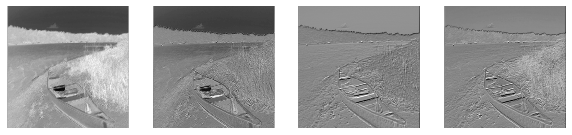

<Figure size 432x288 with 0 Axes>

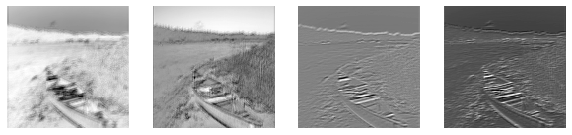

<Figure size 432x288 with 0 Axes>

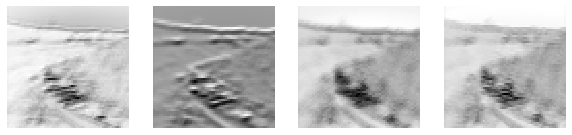

<Figure size 432x288 with 0 Axes>

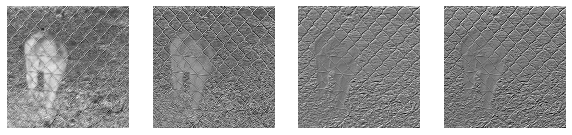

<Figure size 432x288 with 0 Axes>

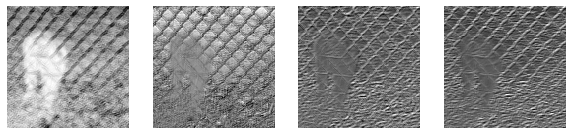

<Figure size 432x288 with 0 Axes>

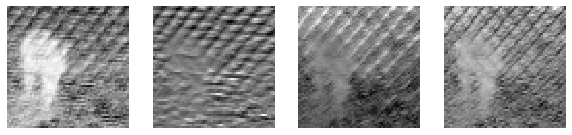

In [0]:
out_image1 = best_model(images[0][0])
out_image2 = best_model(images[1][0])

### Part V


Consider and implement at least two adjustments which you anticipate will improve the model’s ability to generalise on unseen data. While you may completely change the network architecture, please do not use any additional data to train your model other than the ImageNet10 training data provided. Changes related to data loading, transforms, and the training process and parameters are also valid adjustments as long as you justify your choices and provide some form of validation.

#### Removing Max Pool

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 3, stride=2) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 4, stride=2) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 4, stride=2) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(28800, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.re1(self.cv1(x)))

        # Apply the second convolutional layer
        x = self.drop2(self.re2(self.cv2(x)))

        # Apply the third convolutional layer
        x = self.drop3(self.re3(self.cv3(x)))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Epoch / Batch [1 / 39] - Loss: 2.293
Epoch / Batch [1 / 78] - Loss: 2.255
Epoch / Batch [1 / 117] - Loss: 2.211
Epoch / Batch [1 / 156] - Loss: 2.162
Epoch / Batch [1 / 195] - Loss: 2.097
Epoch / Batch [1 / 234] - Loss: 2.081
Epoch / Batch [1 / 273] - Loss: 2.042
Epoch / Batch [1 / 312] - Loss: 2.043
Epoch / Batch [1 / 351] - Loss: 2.030
Epoch / Batch [1 / 390] - Loss: 2.036
Epoch 1 - Loss: 2.124
Accuracy of the epoch throughout training: 21 %
Validation loss = 1.97
Epoch / Batch [2 / 39] - Loss: 1.958
Epoch / Batch [2 / 78] - Loss: 1.963
Epoch / Batch [2 / 117] - Loss: 1.967
Epoch / Batch [2 / 156] - Loss: 2.001
Epoch / Batch [2 / 195] - Loss: 1.968
Epoch / Batch [2 / 234] - Loss: 1.959
Epoch / Batch [2 / 273] - Loss: 1.982
Epoch / Batch [2 / 312] - Loss: 1.907
Epoch / Batch [2 / 351] - Loss: 1.928
Epoch / Batch [2 / 390] - Loss: 1.949
Epoch 2 - Loss: 1.957
Accuracy of the epoch throughout training: 29 %
Validation loss = 1.89
Epoch / Batch [3 / 39] - Loss: 1.931
Epoch / Batch [3 / 78

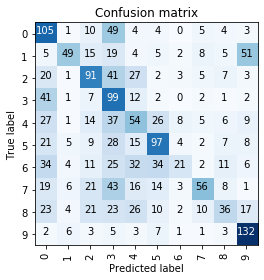

Accuracy of the network on the test images: 41 %


In [0]:
final = FinalNet().to(device)
for epoch in range(10):
    train(device, final, train_loader, valid_loader)
test_model_and_plot(device, final, test_loader)

#### Larger Kernel but with Max Pool

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 16, 7) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(16, 24, 3) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(24, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(25088, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

In [0]:
final = FinalNet().to(device)

In [0]:
for epoch in range(10):
    train(device, final, train_loader, valid_loader)

Epoch / Batch [1 / 39] - Loss: 2.303
Epoch / Batch [1 / 78] - Loss: 2.266
Epoch / Batch [1 / 117] - Loss: 2.182
Epoch / Batch [1 / 156] - Loss: 2.162
Epoch / Batch [1 / 195] - Loss: 2.085
Epoch / Batch [1 / 234] - Loss: 2.071
Epoch / Batch [1 / 273] - Loss: 2.052
Epoch / Batch [1 / 312] - Loss: 2.078
Epoch / Batch [1 / 351] - Loss: 2.074
Epoch / Batch [1 / 390] - Loss: 2.023
Epoch 1 - Loss: 2.127
Accuracy of the epoch throughout training: 21 %
Validation loss = 1.96
Epoch / Batch [2 / 39] - Loss: 1.972
Epoch / Batch [2 / 78] - Loss: 2.008
Epoch / Batch [2 / 117] - Loss: 2.004
Epoch / Batch [2 / 156] - Loss: 1.964
Epoch / Batch [2 / 195] - Loss: 2.010
Epoch / Batch [2 / 234] - Loss: 1.993
Epoch / Batch [2 / 273] - Loss: 1.968
Epoch / Batch [2 / 312] - Loss: 1.899
Epoch / Batch [2 / 351] - Loss: 1.908
Epoch / Batch [2 / 390] - Loss: 1.950
Epoch 2 - Loss: 1.967
Accuracy of the epoch throughout training: 28 %
Validation loss = 1.86
Epoch / Batch [3 / 39] - Loss: 1.906
Epoch / Batch [3 / 78

Confusion matrix, without normalization


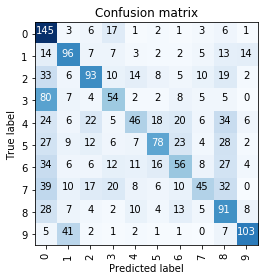

Accuracy of the network on the test images: 44 %


In [0]:
test_model_and_plot(device, final, test_loader)

In [0]:
final

FinalNet(
  (cv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (re1): ReLU()
  (mp1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (cv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (re2): ReLU()
  (mp2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.3, inplace=False)
  (cv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (re3): ReLU()
  (mp3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

#### Experimenting with output features.

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(32, 64, 5) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(64, 128, 5) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(93312, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Epoch / Batch [1 / 39] - Loss: 2.259
Epoch / Batch [1 / 78] - Loss: 2.099
Epoch / Batch [1 / 117] - Loss: 2.075
Epoch / Batch [1 / 156] - Loss: 2.019
Epoch / Batch [1 / 195] - Loss: 2.083
Epoch / Batch [1 / 234] - Loss: 2.060
Epoch / Batch [1 / 273] - Loss: 1.991
Epoch / Batch [1 / 312] - Loss: 1.997
Epoch / Batch [1 / 351] - Loss: 1.936
Epoch / Batch [1 / 390] - Loss: 1.926
Epoch 1 - Loss: 2.044
Accuracy of the epoch throughout training: 24 %
Validation loss = 1.83
Epoch / Batch [2 / 39] - Loss: 1.872
Epoch / Batch [2 / 78] - Loss: 1.869
Epoch / Batch [2 / 117] - Loss: 1.871
Epoch / Batch [2 / 156] - Loss: 1.866
Epoch / Batch [2 / 195] - Loss: 1.840
Epoch / Batch [2 / 234] - Loss: 1.852
Epoch / Batch [2 / 273] - Loss: 1.816
Epoch / Batch [2 / 312] - Loss: 1.840
Epoch / Batch [2 / 351] - Loss: 1.742
Epoch / Batch [2 / 390] - Loss: 1.851
Epoch 2 - Loss: 1.839
Accuracy of the epoch throughout training: 34 %
Validation loss = 1.70
Epoch / Batch [3 / 39] - Loss: 1.739
Epoch / Batch [3 / 78

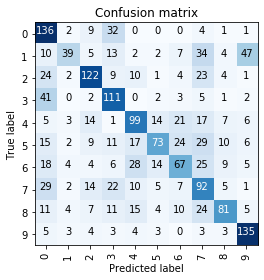

Accuracy of the network on the test images: 53 %


In [0]:
final = FinalNet().to(device)
for epoch in range(10):
    train(device, final, train_loader, valid_loader)
test_model_and_plot(device, final, test_loader)

#### Testing out ADAM

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(32, 64, 5) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(64, 128, 5) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(93312, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Epoch / Batch [1 / 39] - Loss: 3.819
Epoch / Batch [1 / 78] - Loss: 2.317
Epoch / Batch [1 / 117] - Loss: 2.299
Epoch / Batch [1 / 156] - Loss: 2.305
Epoch / Batch [1 / 195] - Loss: 2.285
Epoch / Batch [1 / 234] - Loss: 2.249
Epoch / Batch [1 / 273] - Loss: 2.255
Epoch / Batch [1 / 312] - Loss: 2.252
Epoch / Batch [1 / 351] - Loss: 2.216
Epoch / Batch [1 / 390] - Loss: 2.194
Epoch 1 - Loss: 2.416
Accuracy of the epoch throughout training: 13 %
Validation loss = 2.12
Epoch / Batch [2 / 39] - Loss: 2.167
Epoch / Batch [2 / 78] - Loss: 2.134
Epoch / Batch [2 / 117] - Loss: 2.205
Epoch / Batch [2 / 156] - Loss: 2.171
Epoch / Batch [2 / 195] - Loss: 2.150
Epoch / Batch [2 / 234] - Loss: 2.184
Epoch / Batch [2 / 273] - Loss: 2.097
Epoch / Batch [2 / 312] - Loss: 2.095
Epoch / Batch [2 / 351] - Loss: 2.117
Epoch / Batch [2 / 390] - Loss: 2.122
Epoch 2 - Loss: 2.143
Accuracy of the epoch throughout training: 19 %
Validation loss = 2.07
Epoch / Batch [3 / 39] - Loss: 2.033
Epoch / Batch [3 / 78

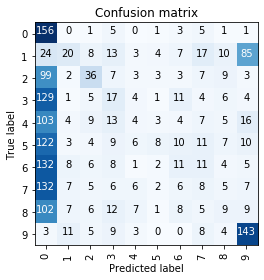

Accuracy of the network on the test images: 22 %


In [27]:
final = FinalNet().to(device)
adam = optim.Adam(final.parameters(), lr=0.001)
for epoch in range(10):
    train(device, final, train_loader, valid_loader, optimizer=adam)
test_model_and_plot(device, final, test_loader)

#### 10 Epochs and Final Net

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(32, 64, 5) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(64, 128, 5) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(93312, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Epoch / Batch [1 / 39] - Loss: 2.288
Epoch / Batch [1 / 78] - Loss: 2.130
Epoch / Batch [1 / 117] - Loss: 2.114
Epoch / Batch [1 / 156] - Loss: 2.041
Epoch / Batch [1 / 195] - Loss: 2.035
Epoch / Batch [1 / 234] - Loss: 1.988
Epoch / Batch [1 / 273] - Loss: 1.980
Epoch / Batch [1 / 312] - Loss: 1.923
Epoch / Batch [1 / 351] - Loss: 1.955
Epoch / Batch [1 / 390] - Loss: 1.921
Epoch 1 - Loss: 2.037
Accuracy of the epoch throughout training: 25 %
Validation loss = 1.82
Epoch / Batch [2 / 39] - Loss: 1.914
Epoch / Batch [2 / 78] - Loss: 1.808
Epoch / Batch [2 / 117] - Loss: 1.849
Epoch / Batch [2 / 156] - Loss: 1.849
Epoch / Batch [2 / 195] - Loss: 1.776
Epoch / Batch [2 / 234] - Loss: 1.760
Epoch / Batch [2 / 273] - Loss: 1.799
Epoch / Batch [2 / 312] - Loss: 1.746
Epoch / Batch [2 / 351] - Loss: 1.739
Epoch / Batch [2 / 390] - Loss: 1.755
Epoch 2 - Loss: 1.800
Accuracy of the epoch throughout training: 36 %
Validation loss = 1.72
Epoch / Batch [3 / 39] - Loss: 1.691
Epoch / Batch [3 / 78

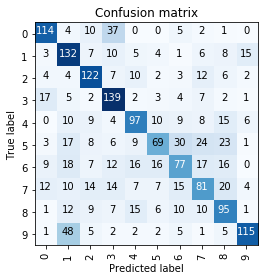

Accuracy of the network on the test images: 57 %


In [32]:
final = FinalNet().to(device)
for epoch in range(15):
    train(device, final, train_loader, valid_loader)
test_model_and_plot(device, final, test_loader)

#### 25 Epochs

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(32, 64, 5) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(64, 128, 5) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(93312, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

Epoch / Batch [1 / 39] - Loss: 2.287
Epoch / Batch [1 / 78] - Loss: 2.165
Epoch / Batch [1 / 117] - Loss: 2.074
Epoch / Batch [1 / 156] - Loss: 2.079
Epoch / Batch [1 / 195] - Loss: 2.110
Epoch / Batch [1 / 234] - Loss: 1.967
Epoch / Batch [1 / 273] - Loss: 2.004
Epoch / Batch [1 / 312] - Loss: 1.990
Epoch / Batch [1 / 351] - Loss: 1.938
Epoch / Batch [1 / 390] - Loss: 1.905
Epoch 1 - Loss: 2.051
Accuracy of the epoch throughout training: 24 %
Validation loss = 1.83
Epoch / Batch [2 / 39] - Loss: 1.856
Epoch / Batch [2 / 78] - Loss: 1.804
Epoch / Batch [2 / 117] - Loss: 1.907
Epoch / Batch [2 / 156] - Loss: 1.851
Epoch / Batch [2 / 195] - Loss: 1.911
Epoch / Batch [2 / 234] - Loss: 1.926
Epoch / Batch [2 / 273] - Loss: 1.845
Epoch / Batch [2 / 312] - Loss: 1.815
Epoch / Batch [2 / 351] - Loss: 1.868
Epoch / Batch [2 / 390] - Loss: 1.788
Epoch 2 - Loss: 1.856
Accuracy of the epoch throughout training: 34 %
Validation loss = 1.65
Epoch / Batch [3 / 39] - Loss: 1.799
Epoch / Batch [3 / 78

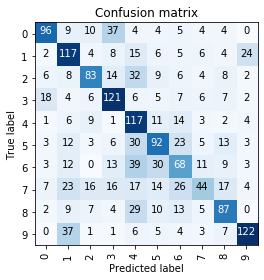

Accuracy of the network on the test images: 52 %


In [34]:
final = FinalNet().to(device)
for epoch in range(25):
    train(device, final, train_loader, valid_loader)
test_model_and_plot(device, final, test_loader)

#### Final Net

In [0]:
# Convolutional neural network
class FinalNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(FinalNet, self).__init__()

        # First Convolutional Layer
        self.cv1 = nn.Conv2d(3, 32, 3) # Input Layers, Output Layers, Kernel Size
        self.re1 = nn.ReLU() # Activation Function
        self.mp1 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop1 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Second Convolutional Layer
        self.cv2 = nn.Conv2d(32, 64, 5) # Input Layers, Output Layers, Kernel Size
        self.re2 = nn.ReLU() # Activation Function
        self.mp2 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop2 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Third Convolutional Layer
        self.cv3 = nn.Conv2d(64, 128, 5) # Input Layers, Output Layers, Kernel Size
        self.re3 = nn.ReLU() # Activation Function
        self.mp3 = nn.MaxPool2d(3, stride=2) # Kernel Size
        self.drop3 = nn.Dropout2d(p=0.3) # p = percentage chance that an element will be dropped.

        # Final fully connected layer
        self.fc1 = nn.Linear(93312, 512) # Takes the flattened tensor from previous layers.
        self.fc2 = nn.Linear(512, num_classes) # Last function outputting a tensor with predictions for each class.
        
    def forward(self, x):

        # Apply the first convolutional layer
        x = self.drop1(self.mp1(self.re1(self.cv1(x))))

        # Apply the second convolutional layer
        x = self.drop2(self.mp2(self.re2(self.cv2(x))))

        # Apply the third convolutional layer
        x = self.drop3(self.mp3(self.re3(self.cv3(x))))

        # Flatten the output so that is a row vector, allowing it to be passed as input to the fully connected layers
        x = x.reshape(x.size(0), -1)

        # Lastly, pass the input to the fully connected layers, and an input that can be thought of as percentages for each class.
        out = self.fc2(self.fc1(x))
        
        # Return the output
        return out

In [0]:
final = FinalNet().to(device)
for epoch in range(15):
    train(device, final, train_loader, valid_loader)
test_model_and_plot(device, final, test_loader)